In [1]:
import os
os.environ['OMP_NUM_THREADS'] = "24"

import numpy as np
import sys
import scipy.stats as st
import matplotlib.pyplot as plt
from matplotlib import rc
font = {'size'   : 22}
rc('font', **font)
#plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
#rc('text', usetex=True)
#plt.rcParams['font.family']='Computer Modern'


import torch
torch.set_num_threads(24)

from torch import nn
from tqdm import tqdm
from torch.nn.modules import Module
from torch.nn import Sequential as Seq, Linear, ReLU, Parameter,LeakyReLU
from torch.utils.data import DataLoader, TensorDataset

In [2]:
def sqrtPos(val):
    """
    Returns 0 if val is negative, otherwiswe the sqrt.
    """
    return sqrt(val) if val > 0 else 0.


def lund(a,b,sample):
        ### this function mimicks Pythia's zLund. It takes as input two parameters, a and b, and a given sample [mT^2,z] and inputs the Lund function value normalized such that f(zMax) = 1

        z = sample[1]
        beff = b*sample[0]

        ### I initialize two ints to asses whether zMax is too low or too high
        peakednearzero = 0
        peakednearunity = 0
        
        ### zMax determination
        if a == 0.0:
            if 1.0 > beff:
                zMax = beff
            else:
                zMax = 1.0
        elif a == 1.0:
            zMax = beff/(beff+1.0)
        else:
            zMax = 0.5 * (beff + 1.0 - np.sqrt( (beff - 1.0)**2 + 4* a * beff)) / (1.0 - a)
        if (zMax > 0.9999 and beff > 100):
             zMax = np.min([zMax, 1.0 - a/beff])

    # get current regime
        if zMax < 0.1:
            peakednearzero = 1
        if zMax > 0.85 and beff > 1.0:
            peakednearunity = 1

        # right now I'll ignore whether it is too small or too large but I'll print it just to keep in mind that it does happen

    # if zMax too small
        if peakednearzero == 1:
            # print("Near Zero")
#             pass
            zDiv = 2.75 * zMax
            fIntLow = zDiv
            fIntHigh = -zDiv * np.log(zDiv)
            fInt = fIntLow + fIntHigh
            fZ = 1.0 if z < zDiv else zDiv/z
            #if z > 0.0 and z < 1.0:
            #    z = zDiv * z if z < zDiv else zDiv/z
        #return 0.0

    # if zMax too large 
        elif peakednearunity == 1:
            # print("Near Unity")
        #return 0.0
#             pass
            rcb = np.sqrt(4. + (1.0 / beff)**2)
            zDiv = rcb - 1.0/zMax - (1.0 / beff) *np.log( zMax * 0.5 * (rcb + 1.0 / beff) )+(a/beff) * np.log(1. - zMax)
            zDiv = np.min([zMax, np.max([0., zDiv])])
            fIntLow = 1.0 / beff
            fIntHigh = 1. - zDiv
            fInt = fIntLow + fIntHigh
            fZ = np.exp( beff * (z - zDiv) ) if z < zDiv else 1.0
            #if z > 0.0 and z < 1.0:
            #    z =  zDiv + np.log(z) / beff if z < zDiv else zDiv + (1. - zDiv) * z

        # Lund function itself 
        if z > 0.0 and z<1.0:
            #fExp = beff * (0.0 - 1. / z)+ 1.0 * np.log(1.0 / z) + a * np.log( (1. -z) )
            fExp = beff * (1. / zMax - 1. / z)+ 1.0*np.log(zMax / z) + a * np.log( (1. - z) / (1. - zMax) )
            fZ = np.exp( np.max( [-50, np.min( [50, fExp]) ]) ) # 50 is chosen to avoid too large exponents
        else:
            fZ = 0.0
                
        return fZ
    
def lund_unnorm(a,b,sample):
        ### this function mimicks Pythia's zLund. It takes as input two parameters, a and b, and a given sample [mT^2,z] and inputs the Lund function value normalized such that f(zMax) = 1

        z = sample[1]
        beff = b*sample[0]

        ### I initialize two ints to asses whether zMax is too low or too high
        peakednearzero = 0
        peakednearunity = 0
        
        ### zMax determination
        if a == 0.0:
            if 1.0 > beff:
                zMax = beff
            else:
                zMax = 1.0
        elif a == 1.0:
            zMax = beff/(beff+1.0)
        else:
            zMax = 0.5 * (beff + 1.0 - np.sqrt( (beff - 1.0)**2 + 4* a * beff)) / (1.0 - a)
        if (zMax > 0.9999 and beff > 100):
             zMax = np.min([zMax, 1.0 - a/beff])

    # get current regime
        if zMax < 0.1:
            peakednearzero = 1
        if zMax > 0.85 and beff > 1.0:
            peakednearunity = 1

        # right now I'll ignore whether it is too small or too large but I'll print it just to keep in mind that it does happen

    # if zMax too small
#         if peakednearzero == 1:
#             print("Near Zero")
#             pass
#             zDiv = 2.75 * zMax
#             fIntLow = zDiv
#             fIntHigh = -zDiv * np.log(zDiv)
#             fInt = fIntLow + fIntHigh
#             fZ = 1.0 if z < zDiv else zDiv/z
            #if z > 0.0 and z < 1.0:
            #    z = zDiv * z if z < zDiv else zDiv/z
        #return 0.0

    # if zMax too large 
#         elif peakednearunity == 1:
            # print("Near Unity")
        #return 0.0
#             pass
#             rcb = np.sqrt(4. + (1.0 / beff)**2)
#             zDiv = rcb - 1.0/zMax - (1.0 / beff) *np.log( zMax * 0.5 * (rcb + 1.0 / beff) )+(a/beff) * np.log(1. - zMax)
#             zDiv = np.min([zMax, np.max([0., zDiv])])
#             fIntLow = 1.0 / beff
#             fIntHigh = 1. - zDiv
#             fInt = fIntLow + fIntHigh
#             fZ = np.exp( beff * (z - zDiv) ) if z < zDiv else 1.0
            #if z > 0.0 and z < 1.0:
            #    z =  zDiv + np.log(z) / beff if z < zDiv else zDiv + (1. - zDiv) * z

        # Lund function itself 
        if 1==1:
            if z > 0.0 and z<1.0:
                #fExp = beff * (0.0 - 1. / z)+ 1.0 * np.log(1.0 / z) + a * np.log( (1. -z) )
                fExp = beff * (- 1. / z)+ 1.0*np.log(1.0 / z) + a * np.log( (1. - z))
                fZ = np.exp( np.max( [-50, np.min( [50, fExp]) ]) ) # 50 is chosen to avoid too large exponents
            else:
                fZ = 0.0
                
        return fZ

    
def lund_unnorm_max(a,b,sample):
        ### this function mimicks Pythia's zLund. It takes as input two parameters, a and b, and a given sample [mT^2,z] and inputs the Lund function value normalized such that f(zMax) = 1

        z = sample[1]
        beff = b*sample[0]

        
        ### zMax determination
        if a == 0.0:
            if 1.0 > beff:
                zMax = beff
            else:
                zMax = 1.0
        elif a == 1.0:
            zMax = beff/(beff+1.0)
        else:
            zMax = 0.5 * (beff + 1.0 - np.sqrt( (beff - 1.0)**2 + 4* a * beff)) / (1.0 - a)
        if (zMax > 0.9999 and beff > 100):
             zMax = np.min([zMax, 1.0 - a/beff])

        # Lund function itself 
        if zMax > 0.0 and zMax<1.0:
            #fExp = beff * (0.0 - 1. / z)+ 1.0 * np.log(1.0 / z) + a * np.log( (1. -z) )
            fExp = beff * (- 1. / zMax)+ 1.0*np.log(1.0 / zMax) + a * np.log( (1. - zMax))
            fZ = np.exp( np.max( [-50, np.min( [50, fExp]) ]) ) # 50 is chosen to avoid too large exponents
        else:
            fZ = 0.0
                
        return fZ

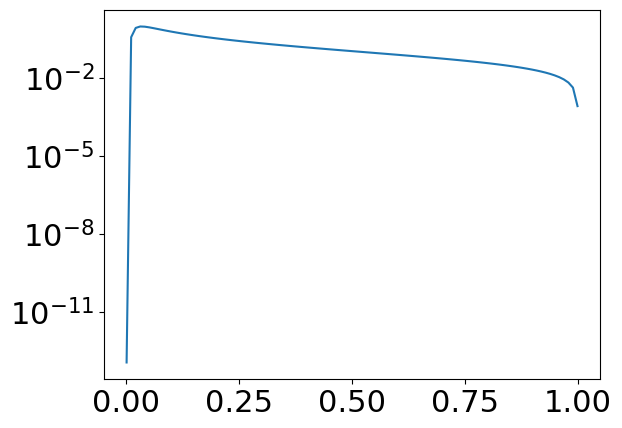

In [3]:
mT2 = 0.139**2+0.2**2
zvals = np.linspace(1e-3,0.999,100)
a_base = 0.68
b_base = 0.58
probs = np.array([lund_unnorm(a_base,b_base,[mT2,zval])/lund_unnorm_max(a_base,b_base,[mT2,zval]) for zval in zvals])
plt.plot(zvals,probs)
plt.yscale('log')

In [4]:
N = int(1e5)
max_length = int(10000)
events = np.zeros((N,max_length,2))
labels = -np.ones((N,max_length))
a_vals = np.linspace(0.2,1,100)
b_vals = np.linspace(0.2,1,100)

# Kvals = np.array([[lund_unnorm_max(a_val,b_val,[mT2,0.5]) for a_val in a_vals] for b_val in b_vals])
mT2vals = np.linspace(0.139**2,5,100)
Kvals = np.array([[[lund_unnorm_max(a_val,b_val,[mT2_val,0.5]) for a_val in a_vals] for b_val in b_vals] for mT2_val in mT2vals])
K = 1.01*np.max(Kvals)
print(K)
a_true = 0.76
b_true = 0.98
a_init = 0.30
b_init = 0.80
mass = 0.139

# for n in range(N):
#     event = []
#     label = []
#     pT = np.sqrt((0.335*np.random.randn())**2+(0.335*np.random.randn())**2)
#     mT2 = pT**2+mass**2
#     a = 0
#     while a == 0:
#         z_try = np.random.rand()
#         prob = lund_unnorm(a_base,b_base,[mT2,z_try])
#         prob*=1/K
#         u = np.random.rand()
#         if prob > u:
#             event.append([mT2,z_try])
#             label.append(1.0)
#             a = 1
#         else:
#             event.append([mT2,z_try])
#             label.append(0.0)
#     events[n,:len(event)]=event
#     labels[n,:len(label)]=label

96.07958885600712


In [5]:
# np.save('events_Lund.npy',events)
# np.save('labels_Lund.npy',labels)
events = np.load('events_Lund.npy')
labels = np.load('labels_Lund.npy')

In [6]:
measurements_base = events[labels==1]

In [7]:
measurements_true = np.zeros((N,2))
# for n in range(N):
#     event = []
#     label = []
#     pT = np.sqrt((0.335*np.random.randn())**2+(0.335*np.random.randn())**2)
#     mT2 = pT**2+mass**2
#     a = 0
#     while a == 0:
#         z_try = np.random.rand()
#         prob = lund(a_true,b_true,[mT2,z_try])
#         u = np.random.rand()
#         if prob > u:
#             measurements_true[n]=[mT2,z_try]
#             a = 1
#         else:
#             pass
    
# np.save('measurements_true_Lund.npy',measurements_true)
measurements_true = np.load('measurements_true_Lund.npy')

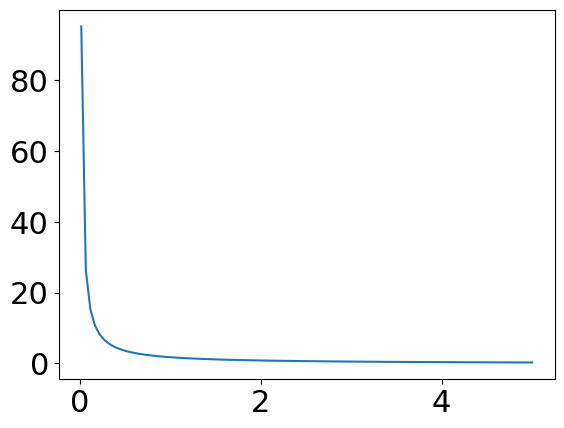

In [8]:
plt.plot(mT2vals,np.max(np.max(Kvals,axis=1),axis=1))

In [9]:
# a_vals, b_vals

In [10]:
np.argmax([np.where(label == -1)[0][0] for label in labels]),np.max([np.where(label == -1)[0][0] for label in labels])

(77944, 8948)

In [11]:
labels[np.argmax([np.where(label == -1)[0][0] for label in labels])]

array([ 0.,  0.,  0., ..., -1., -1., -1.])

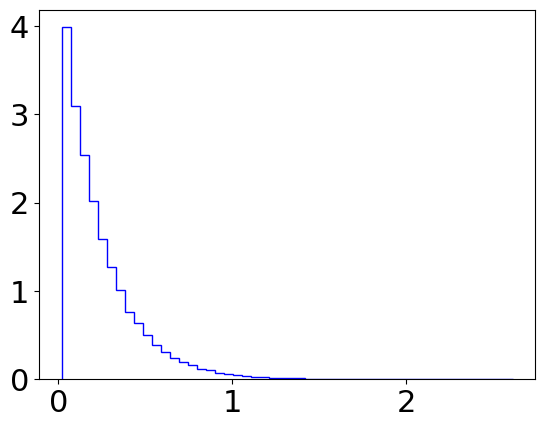

In [12]:
# plt.hist(events[labels>=0][:,0],bins=100,density=True,histtype='step',color='black');
# plt.hist(events[labels==0][:,0],bins=100,density=True,histtype='step',color='blue',linestyle='dashed');
mT2_pdf, mT2_bins, _ = plt.hist(events[labels==1][:,0],bins=50,density=True,histtype='step',color='blue');

In [13]:
mT2_pdf

array([3.98277075e+00, 3.09597441e+00, 2.53885720e+00, 2.01916407e+00,
       1.58898008e+00, 1.27531228e+00, 1.00485580e+00, 7.61599288e-01,
       6.32929905e-01, 5.01174000e-01, 3.87937226e-01, 3.07880563e-01,
       2.46150125e-01, 1.93293436e-01, 1.56255173e-01, 1.15937480e-01,
       1.04555931e-01, 7.42694341e-02, 5.71006559e-02, 5.18921501e-02,
       4.24396767e-02, 3.02864965e-02, 2.43063603e-02, 1.87120393e-02,
       1.56255173e-02, 1.31177182e-02, 1.08028268e-02, 8.48793533e-03,
       5.40141339e-03, 4.82269053e-03, 3.27942956e-03, 2.31489145e-03,
       2.50779908e-03, 2.12198383e-03, 1.35035335e-03, 1.35035335e-03,
       1.73616859e-03, 9.64538106e-04, 1.15744573e-03, 7.71630485e-04,
       1.92907621e-04, 5.78722863e-04, 3.85815242e-04, 3.85815242e-04,
       1.92907621e-04, 0.00000000e+00, 0.00000000e+00, 3.85815242e-04,
       0.00000000e+00, 1.92907621e-04])

In [14]:
z_bins = np.linspace(0,1,1000)
normalization_base = np.ones(len(mT2_pdf))
normalization_true = np.ones(len(mT2_pdf))
for nmT2_bin in range(len(mT2_pdf)):
    mT2_val = 0.5*(mT2_bins[nmT2_bin+1]+mT2_bins[nmT2_bin])
    normalization_base[nmT2_bin] = np.sum([lund_unnorm(a_base,b_base,[mT2_val,0.5*(z_bins[nz_bin+1]+z_bins[nz_bin])])*(z_bins[nz_bin+1]-z_bins[nz_bin]) for nz_bin in range(len(z_bins)-1)])
    normalization_true[nmT2_bin] = np.sum([lund_unnorm(a_true,b_true,[mT2_val,0.5*(z_bins[nz_bin+1]+z_bins[nz_bin])])*(z_bins[nz_bin+1]-z_bins[nz_bin]) for nz_bin in range(len(z_bins)-1)])

In [15]:
z_bins = np.linspace(0,1,100)
probs_base = np.zeros(len(z_bins)-1)
probs_true = np.zeros(len(z_bins)-1)
for nz_bin in range(len(z_bins)-1):
    z_val = 0.5*(z_bins[nz_bin+1]+z_bins[nz_bin])
    for nmT2_bin in range(len(mT2_bins)-1):
        mT2_val = 0.5*(mT2_bins[nmT2_bin+1]+mT2_bins[nmT2_bin])
        probs_base[nz_bin] += lund_unnorm(a_base,b_base,[mT2_val,z_val])*mT2_pdf[nmT2_bin]*(mT2_bins[nmT2_bin+1]-mT2_bins[nmT2_bin])/normalization_base[nmT2_bin]
        probs_true[nz_bin] += lund_unnorm(a_true,b_true,[mT2_val,z_val])*mT2_pdf[nmT2_bin]*(mT2_bins[nmT2_bin+1]-mT2_bins[nmT2_bin])/normalization_true[nmT2_bin]

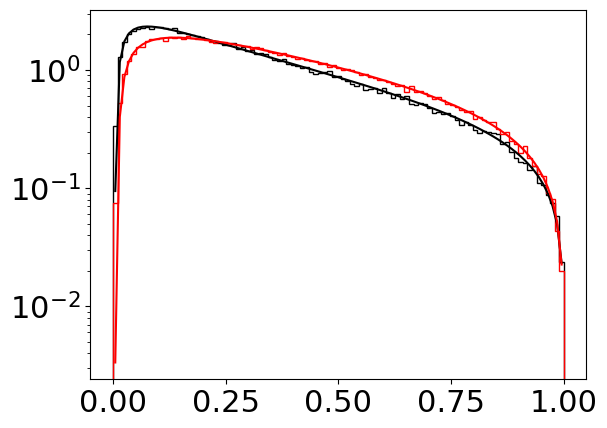

In [16]:
plt.hist(measurements_base[:,1],bins=z_bins,density=True,histtype='step',color='black');

plt.hist(measurements_true[:,1],bins=z_bins,density=True,histtype='step',color='red');


plt.plot(0.5*(z_bins[1:]+z_bins[:-1]),probs_base,color='black')
plt.plot(0.5*(z_bins[1:]+z_bins[:-1]),probs_true,color='red')

plt.yscale('log')

In [88]:
z_bins = np.linspace(0,1,100)


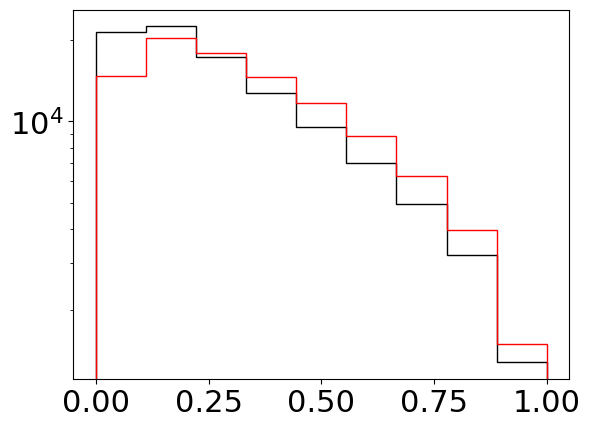

In [18]:
z_bins_chi = np.linspace(0,1,10)

num_measurements_base, _, _ = plt.hist(measurements_base[:,1],bins=z_bins_chi,density=False,histtype='step',color='black');

num_measurements_true, _, _ = plt.hist(measurements_true[:,1],bins=z_bins_chi,density=False,histtype='step',color='red');


# plt.plot(0.5*(z_bins[1:]+z_bins[:-1]),probs_base,color='black')
# plt.plot(0.5*(z_bins[1:]+z_bins[:-1]),probs_true,color='red')

plt.yscale('log')

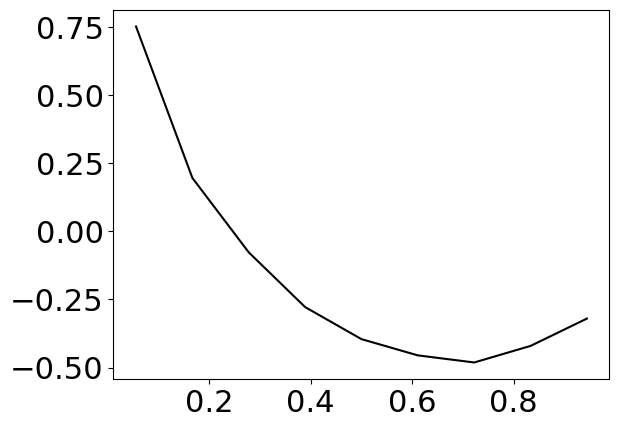

In [19]:
plt.plot(0.5*(z_bins_chi[1:]+z_bins_chi[:-1]),-2*(np.log(num_measurements_true)-np.log(num_measurements_base)),color='black')

In [20]:
np.sum(((num_measurements_true-num_measurements_base)/np.sqrt(num_measurements_base))**2)

4097.062188150648

In [21]:
theta_base = torch.tensor([a_base,b_base])

events_torch = torch.tensor(np.array(events,np.float32))
labels_torch = torch.tensor(np.array(labels,np.float32))
measurements_base_torch = torch.tensor(np.array(measurements_base,np.float32))
measurements_true_torch = torch.tensor(np.array(measurements_true,np.float32))

In [22]:
class LundWeightNN(nn.Module):
    def __init__(self,theta_base,layers=[nn.Linear(2, 16),nn.ReLU(),nn.Linear(16,32),nn.ReLU(),nn.Linear(32,1),nn.Sigmoid()],oversampling=2.001):
        super(LundWeightNN, self).__init__()
        self.theta_base = theta_base
        self.oversampling = oversampling
        self.layers = nn.ModuleList()
        for layer in layers:
            self.layers.append(layer)
        
    def prob_function(self,X):
        output = X
#         print(output.shape)
        for layer in self.layers:
            output = layer(output)
#             print(output.shape)
        return 0.99*self.oversampling*output[:,0]
    
    def prob_function_base(self,X,theta_eval):
        ### this function mimicks Pythia's zLund. It takes as input two parameters, a and b, and a given sample [mT^2,z] and inputs the Lund function value unnormalized
        z = X[:,1]
        mT2 = X[:,0]
        a_eval = theta_eval[0]
        b_eval = theta_eval[1]
        output = torch.ones(z.shape)


        beff = b_eval * mT2
        
        ### No zMax determination

        # right now I'll ignore whether it is too small or too large

        # Lund function itself 

        fExp = beff * (- 1. / z)+ 1.0*torch.log(1.0 / z) + a_eval * torch.log( (1. - z))
#         I won't check for very large or small exponents to avoid adding step functions
#         fExp = torch.where(fExp<50,fExp,50)
#         fExp = torch.where(fExp>-50,fExp,-50)
        output = torch.exp(fExp) # 50 is chosen to avoid too large exponents
#         I won't impose 0s at 0,1 to avoid adding step functions
#         output[z==0] = 0.0
#         output[z==1] = 0.0
        
        
        return output
        
    def forward(self,z,label):
        output = torch.ones((z.shape[0],z.shape[1]))
#         print(output.shape)
        output[label==1] = self.prob_function(z[label==1])/self.prob_function_base(z[label==1],self.theta_base)
        output[label==0] = (self.oversampling-self.prob_function(z[label==0]))/(self.oversampling-self.prob_function_base(z[label==0],self.theta_base))
        output = torch.prod(output,1)
        return output
    

In [23]:
class LundWeight(nn.Module):
    def __init__(self,theta_base,theta_init,oversampling=2.001):
        super(LundWeight, self).__init__()
        self.theta_base = theta_base
        self.theta = torch.nn.Parameter(theta_init.clone())
        self.oversampling = oversampling
    
    def prob_function(self,X,theta_eval):
        ### this function mimicks Pythia's zLund. It takes as input two parameters, a and b, and a given sample [mT^2,z] and inputs the Lund function value unnormalized
        z = X[:,1]
        mT2 = X[:,0]
        a_eval = theta_eval[0]
        b_eval = theta_eval[1]
        output = torch.ones(z.shape)


        beff = b_eval * mT2
        
        ### No zMax determination

        # right now I'll ignore whether it is too small or too large

        # Lund function itself 

        fExp = beff * (- 1. / z)+ 1.0*torch.log(1.0 / z) + a_eval * torch.log( (1. - z))
#         I won't check for very large or small exponents to avoid adding step functions
#         fExp = torch.where(fExp<50,fExp,50)
#         fExp = torch.where(fExp>-50,fExp,-50)
        output = torch.exp(fExp) # 50 is chosen to avoid too large exponents
#         I won't impose 0s at 0,1 to avoid adding step functions
#         output[z==0] = 0.0
#         output[z==1] = 0.0
        
        
        return output
        
    def forward(self,z,label):
        output = torch.ones((z.shape[0],z.shape[1]))
#         print(output.shape)
        output[label==1] = self.prob_function(z[label==1],self.theta)/self.prob_function(z[label==1],self.theta_base)
        output[label==0] = (self.oversampling-self.prob_function(z[label==0],self.theta))/(self.oversampling-self.prob_function(z[label==0],self.theta_base))
        output = torch.prod(output,1)
        return output
    

In [82]:
layers = [nn.Linear(2, 16),nn.ReLU(),nn.Linear(16,32),nn.ReLU(),nn.Linear(32,32),nn.ReLU(),nn.Linear(32,1),nn.Sigmoid()]
weight_getter = LundWeightNN(theta_base=theta_base,layers=layers,oversampling=K)
# weight_getter = LundWeight(theta_base=theta_base,theta_init=torch.tensor([a_base,b_base]),oversampling=K)

In [83]:
weight_getter.oversampling

96.07958885600712

In [84]:
events_torch[labels_torch==1].shape

torch.Size([100000, 2])

In [85]:
w_init = weight_getter(events_torch,labels_torch).detach().numpy()

In [86]:
w_init.shape

(100000,)

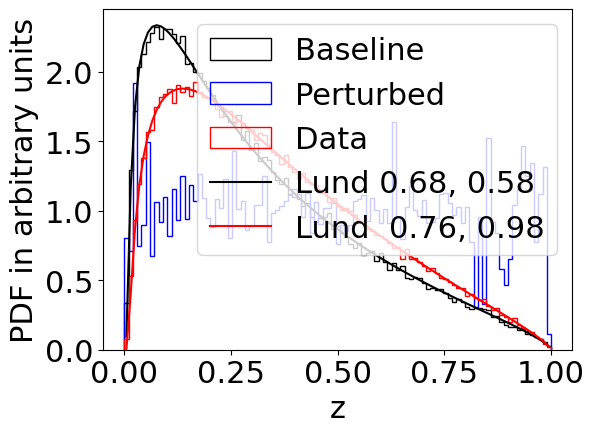

In [89]:
plt.hist(measurements_base[:,1],bins=z_bins,density=True,histtype='step',color='black',label='Baseline');
plt.hist(measurements_base[:,1],bins=z_bins,density=True,weights=w_init,histtype='step',color='blue',label='Perturbed');
plt.hist(measurements_true[:,1],bins=z_bins,density=True,histtype='step',color='red',label='Data');

plt.plot(0.5*(z_bins[1:]+z_bins[:-1]),probs_base,color='black',label='Lund '+str(a_base)+', '+str(b_base))
# plt.plot(0.5*(z_bins[1:]+z_bins[:-1]),probs_init,color='blue',label='Lund '+str(a_init)+', '+str(b_init))
plt.plot(0.5*(z_bins[1:]+z_bins[:-1]),probs_true,color='red',label='Lund  '+str(a_true)+', '+str(b_true))

plt.xlabel('z')
plt.ylabel('PDF in arbitrary units')
plt.legend(loc='upper right')
plt.tight_layout()
# plt.savefig('initial_LundNN.pdf')

# Chi2 approach

In [30]:
measurements_base_binned_torch=torch.zeros((len(measurements_base_torch),len(z_bins_chi)-1))
measurements_true_binned_torch=torch.zeros((len(measurements_true_torch),len(z_bins_chi)-1))
for n_zbin_chi, z_bin_chi_lower in enumerate(torch.tensor(np.array(z_bins_chi,np.float32))[:-1]):
    z_bin_chi_upper = torch.tensor(np.array(z_bins_chi,np.float32))[n_zbin_chi+1]
    print(n_zbin_chi, z_bin_chi_lower,z_bin_chi_upper)
    indexes_base = torch.tensor([a and b for a,b in zip(measurements_base_torch[:,1]>=z_bin_chi_lower,measurements_base_torch[:,1]<z_bin_chi_upper)])
#     print(measurements_base_binned_torch[:,n_zbin_chi].shape)
    measurements_base_binned_torch[:,n_zbin_chi][indexes_base]+=1
    indexes_true = torch.tensor([a and b for a,b in zip(measurements_true_torch[:,1]>=z_bin_chi_lower,measurements_true_torch[:,1]<z_bin_chi_upper)])
    measurements_true_binned_torch[:,n_zbin_chi][indexes_true]+=1
    
    #print(num_measurements_base[n_zbin_chi],torch.sum(indexes_base))
    

0 tensor(0.) tensor(0.1111)
1 tensor(0.1111) tensor(0.2222)
2 tensor(0.2222) tensor(0.3333)
3 tensor(0.3333) tensor(0.4444)
4 tensor(0.4444) tensor(0.5556)
5 tensor(0.5556) tensor(0.6667)
6 tensor(0.6667) tensor(0.7778)
7 tensor(0.7778) tensor(0.8889)
8 tensor(0.8889) tensor(1.)


In [31]:
torch.sum(torch.pow((torch.sum(measurements_true_binned_torch,axis=0)-torch.sum(measurements_base_binned_torch,axis=0))/torch.sqrt(torch.sum(measurements_base_binned_torch,axis=0)),2.0))

tensor(4097.0620)

In [33]:
torch.sum(torch.pow((torch.sum(measurements_true_binned_torch,axis=0)-torch.sum(measurements_base_binned_torch,axis=0))/torch.sqrt(torch.sum(measurements_base_binned_torch,axis=0)+torch.sum(measurements_true_binned_torch,axis=0)),2.0))

tensor(2156.4858)

In [47]:
def chi_sqr_function(t,y,w):
#     print((w*torch.pow(t-y,2)).shape)
    loss_fn = torch.sum(torch.pow(torch.sum((t-w*y),axis=0)/torch.sqrt(torch.sum(w*y+t,axis=0)),2.0))
    return loss_fn#(t,y)

In [48]:
class sim_Dataset(torch.utils.data.Dataset):
    """
    Joins the x and y into a dataset, so that it can be used by the pythorch syntax.
    """

    def __init__(self, event,label,measurement):
        self.event = event
        self.label = label
        self.measurement = measurement

    def __len__(self):
        return len(self.event)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = [self.event[idx], self.label[idx],self.measurement[idx]]
        return sample

In [49]:
class measured_Dataset(torch.utils.data.Dataset):
    """
    Joins the x and y into a dataset, so that it can be used by the pythorch syntax.
    """

    def __init__(self, measurement):
        self.measurement = measurement

    def __len__(self):
        return len(self.measurement)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = self.measurement[idx]
        return sample

In [116]:
sim_dataset = DataLoader(sim_Dataset(events_torch,labels_torch,measurements_base_binned_torch),batch_size=1024)
measured_dataset = DataLoader(measured_Dataset(measurements_true_binned_torch),batch_size=1024)

In [117]:
optimizer = torch.optim.Adam(weight_getter.parameters(), lr=0.01)

In [118]:
chi_sqr_function(measurement,measurement_sim,torch.ones(len(measurement_sim)).reshape(-1,1))

tensor(206.2021)

In [119]:
torch.sum(measurement,axis=0),torch.sum(measurement_sim,axis=0)

(tensor([1435., 2004., 1728., 1464., 1144.,  855.,  628.,  371.,  155.]),
 tensor([2053., 2204., 1737., 1174.,  917.,  743.,  483.,  345.,  128.]))

In [130]:
nepochs = 100
for nepoch in range(nepochs):
    total_loss = 0
    for batch, ((event,label,measurement_sim),measurement) in enumerate(zip(sim_dataset,measured_dataset)):
        #print(X.shape,y.shape)
        optimizer.zero_grad()  # Clear gradients.
        pred = weight_getter(event,label)
        loss = chi_sqr_function(measurement,measurement_sim,pred.reshape(-1,1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    total_loss*=1.0/len(sim_dataset.dataset)
    print(nepoch,total_loss)#,weight_getter.theta)

0 0.011141855309009553
1 0.01098731687307358
2 0.010863298633098603
3 0.010746765668392182
4 0.010624953718185426
5 0.01050868353843689
6 0.010401929214000703
7 0.010303259558677674
8 0.010213895509243013
9 0.010133271880149843
10 0.010054446034431458
11 0.00998530380010605
12 0.009921591269969941
13 0.009861796000003815
14 0.009805036549568177
15 0.009753187205791474
16 0.0097026655125618
17 0.009654464304447176
18 0.009611616525650025
19 0.009564941482543946
20 0.009526208946704865
21 0.009482429671287538
22 0.00944176088809967
23 0.009399885721206666
24 0.00935846593618393
25 0.00931706489801407
26 0.009275230123996735
27 0.009235040640830994
28 0.009193539779186249
29 0.009156618072986603
30 0.00911832190990448
31 0.009083486320972443
32 0.009051652970314027
33 0.009018263993263245
34 0.00898633089542389
35 0.00895407871723175
36 0.008926658718585969
37 0.008896247446537019
38 0.008870656287670137
39 0.00884459755420685
40 0.00881677036523819
41 0.008792072560787201
42 0.0087668419

In [106]:
# weight_getter.theta

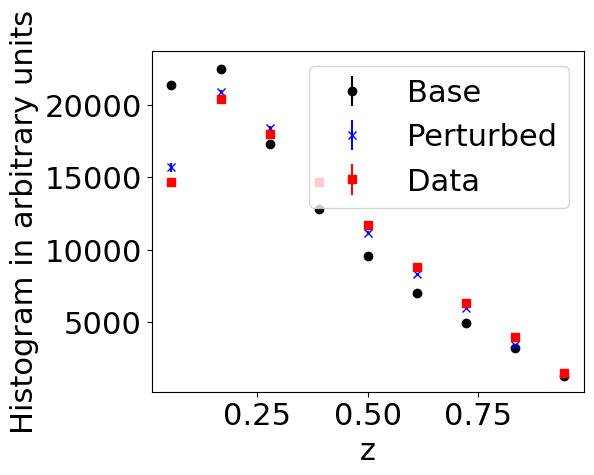

In [121]:
#plt.plot(0.5*(z_bins_chi[1:]+z_bins_chi[:-1]),torch.sum(measurements_base_binned_torch,axis=0).detach().numpy(),'ko',label='Base')
yields=torch.sum(measurements_base_binned_torch,axis=0).detach().numpy()
error=np.sqrt(yields)
plt.errorbar(x=0.5*(z_bins_chi[1:]+z_bins_chi[:-1]),y=yields,yerr=error,fmt='ko',label='Base')

weights_final= weight_getter(events_torch,labels_torch).reshape(-1,1)
yields=torch.sum(weights_final*measurements_base_binned_torch,axis=0).detach().numpy()
error=np.sqrt(torch.sum((weights_final**2)*measurements_base_binned_torch,axis=0).detach().numpy())
plt.errorbar(x=0.5*(z_bins_chi[1:]+z_bins_chi[:-1]),y=yields,yerr=error,fmt='bx',label='Perturbed')

yields=torch.sum(measurements_true_binned_torch,axis=0).detach().numpy()
error=np.sqrt(yields)
plt.errorbar(x=0.5*(z_bins_chi[1:]+z_bins_chi[:-1]),y=yields,yerr=error,fmt='rs',label='Data')

plt.xlabel('z')
plt.ylabel('Histogram in arbitrary units')
plt.legend(loc='upper right')
plt.tight_layout()

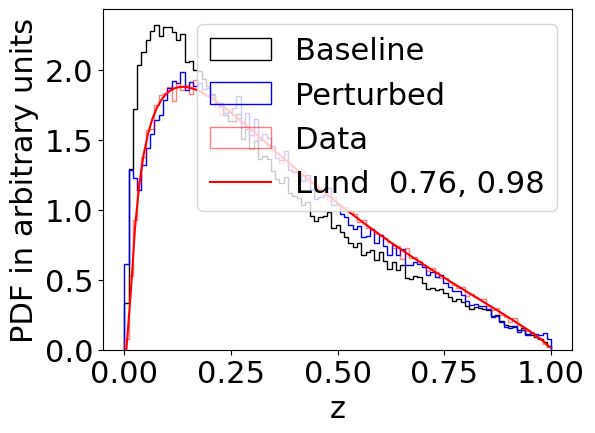

In [122]:
plt.hist(measurements_base[:,1],bins=z_bins,density=True,histtype='step',color='black',label='Baseline');
plt.hist(measurements_base[:,1],bins=z_bins,density=True,weights=weight_getter(events_torch,labels_torch).detach().numpy(),histtype='step',color='blue',label='Perturbed');
plt.hist(measurements_true[:,1],bins=z_bins,density=True,histtype='step',color='red',label='Data',alpha=0.5);

plt.plot(0.5*(z_bins[1:]+z_bins[:-1]),probs_true,color='red',label='Lund  '+str(a_true)+', '+str(b_true))

plt.xlabel('z')
plt.ylabel('PDF in arbitrary units')
plt.legend(loc='upper right')
plt.tight_layout()
# plt.savefig('final_LundNN.pdf')

In [123]:
z_bins = np.linspace(0,1,1000)

normalization_learned = np.ones(len(mT2_pdf))
for nmT2_bin in range(len(mT2_pdf)):
    mT2_val = 0.5*(mT2_bins[nmT2_bin+1]+mT2_bins[nmT2_bin])
    normalization_learned[nmT2_bin] = np.sum([weight_getter.prob_function(torch.tensor(np.array([mT2_val,0.5*(z_bins[nz_bin+1]+z_bins[nz_bin])],np.float32).reshape(1,-1))).detach().numpy()*(z_bins[nz_bin+1]-z_bins[nz_bin]) for nz_bin in range(len(z_bins)-1)])


In [124]:
normalization_learned

array([2.24217868e+00, 2.04722738e+00, 1.84445953e+00, 1.64399588e+00,
       1.45172453e+00, 1.27157640e+00, 1.10613489e+00, 9.56455946e-01,
       8.22863996e-01, 7.04803526e-01, 6.01226449e-01, 5.11037230e-01,
       4.33174074e-01, 3.66256237e-01, 3.08726728e-01, 2.59488225e-01,
       2.17601329e-01, 1.82100624e-01, 1.52044922e-01, 1.26608238e-01,
       1.05042219e-01, 8.67095366e-02, 7.11895972e-02, 5.81392720e-02,
       4.72595394e-02, 3.84032875e-02, 3.12372874e-02, 2.54792646e-02,
       2.07583588e-02, 1.68893095e-02, 1.37218609e-02, 1.11310128e-02,
       9.01465677e-03, 7.28879217e-03, 5.88320009e-03, 4.74028988e-03,
       3.81233776e-03, 3.05994414e-03, 2.45076558e-03, 1.95845845e-03,
       1.56125252e-03, 1.24153192e-03, 9.85165942e-04, 7.79906055e-04,
       6.15796540e-04, 4.84928460e-04, 3.80829762e-04, 2.98172410e-04,
       2.32666280e-04, 1.80860588e-04])

In [125]:
z_bins = np.linspace(0,1,100)
probs_learned = np.zeros(len(z_bins)-1)
for nz_bin in range(len(z_bins)-1):
    z_val = 0.5*(z_bins[nz_bin+1]+z_bins[nz_bin])
    for nmT2_bin in range(len(mT2_bins)-1):
        mT2_val = 0.5*(mT2_bins[nmT2_bin+1]+mT2_bins[nmT2_bin])
        probs_learned[nz_bin] += weight_getter.prob_function(torch.tensor(np.array([mT2_val,z_val],np.float32).reshape(1,-1))).detach().numpy()*mT2_pdf[nmT2_bin]*(mT2_bins[nmT2_bin+1]-mT2_bins[nmT2_bin])/normalization_learned[nmT2_bin]

Text(0, 0.5, 'Sampling function')

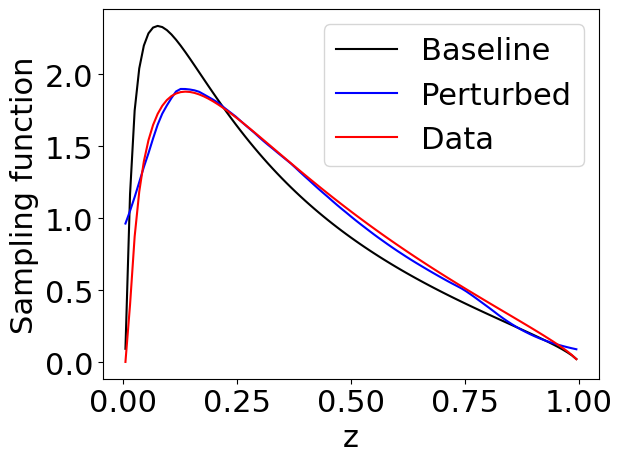

In [126]:
plt.plot(0.5*(z_bins[1:]+z_bins[:-1]),probs_base,color='black',label='Baseline')
plt.plot(0.5*(z_bins[1:]+z_bins[:-1]),probs_learned,color='blue',label='Perturbed')
plt.plot(0.5*(z_bins[1:]+z_bins[:-1]),probs_true,color='red',label='Data')

plt.legend(loc='upper right')
plt.xlabel('z')
plt.ylabel('Sampling function')
# plt.savefig('learned_LundNN.pdf')

Text(0.5, 1.0, 'MSE = 0.1065')

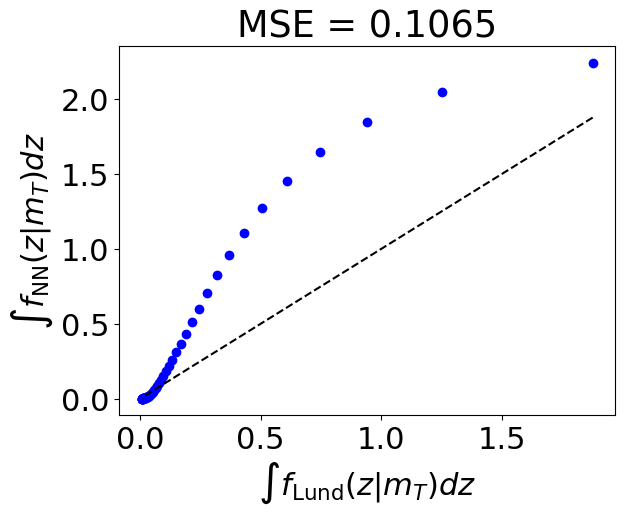

In [127]:
plt.plot(normalization_true,normalization_learned,'bo')
plt.plot(normalization_true,normalization_true,color='black',linestyle='dashed')
plt.xlabel('$\int  f_{\mathrm{Lund}}(z|m_{T}) dz$')
plt.ylabel('$\int  f_{\mathrm{NN}}(z|m_{T}) dz$')
plt.title('MSE = '+str(np.round(np.mean((normalization_true-normalization_learned)**2 ),4)))

In [128]:
np.mean(w_init),np.mean(weight_getter(events_torch,labels_torch).detach().numpy())

(1.000365, 0.9988852)

In [129]:
1-np.mean(w_init),1-np.mean(weight_getter(events_torch,labels_torch).detach().numpy())

(-0.0003650188446044922, 0.0011147856712341309)

# GAN-approach

In [ ]:
def loss_function(t,y,w):
#     print((w*torch.pow(t-y,2)).shape)
    loss_fn = torch.mean(w*torch.pow(t-y,2.0))
    return loss_fn#(t,y)

In [ ]:
torch.histogram(measurements_true_torch[:,1],torch.tensor(np.array(z_bins_chi,np.float32)))

In [ ]:
weight_getter.parameters()

In [ ]:
class sim_Dataset(torch.utils.data.Dataset):
    """
    Joins the x and y into a dataset, so that it can be used by the pythorch syntax.
    """

    def __init__(self, event,label,measurement):
        self.event = event
        self.label = label
        self.measurement = measurement

    def __len__(self):
        return len(self.event)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = [self.event[idx], self.label[idx],self.measurement[idx]]
        return sample

In [ ]:
num_measurements_true

In [ ]:
class measured_Dataset(torch.utils.data.Dataset):
    """
    Joins the x and y into a dataset, so that it can be used by the pythorch syntax.
    """

    def __init__(self, measurement):
        self.measurement = measurement

    def __len__(self):
        return len(self.measurement)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = self.measurement[idx]
        return sample

In [ ]:
class Discriminator(nn.Module):
    def __init__(self,layers=[nn.Linear(2, 16),nn.ReLU(),nn.Linear(16,32),nn.ReLU(),nn.Linear(32,1)]):
        super(Discriminator, self).__init__()
        self.layers = nn.ModuleList()
        for layer in layers:
            self.layers.append(layer)
        
    def forward(self,X):
        output = X
        for layer in self.layers:
            output = layer(output)
        return output[:,0]

In [ ]:
sim_dataset = DataLoader(sim_Dataset(events_torch,labels_torch,measurements_base_torch),batch_size=1024)
measured_dataset = DataLoader(measured_Dataset(measurements_true_torch),batch_size=1024)

In [ ]:
layers=[nn.Linear(2, 32),nn.ReLU(),nn.Linear(32, 32),nn.ReLU(),nn.Linear(32, 32),nn.ReLU(),nn.Linear(32, 1),nn.Sigmoid()]
discriminator = Discriminator(layers=layers)

In [ ]:
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=0.1)
optimizerW = torch.optim.Adam(weight_getter.parameters(), lr=0.001)

In [ ]:
pdf_base, binsmT2, binsz, _ = plt.hist2d(measurements_base[:,0],measurements_base[:,1],bins=10);
plt.show()
pdf_true, binsmT2, binsz, _ = plt.hist2d(measurements_true[:,0],measurements_true[:,1],bins=[binsmT2,binsz]);

In [ ]:
pdf_true/pdf_base

In [ ]:
nepochs = 1
ndisc_per_epoch = 10
ngen_per_epoch = 10

for nepoch in range(nepochs):
    # Discriminator training

    for ndisc_epoch in range(ndisc_per_epoch):
        #weight_getter.eval()
        #weight_getter.zero_grad()
        discriminator.zero_grad()
        # train with measurements
        total_loss = 0
        
        for batch, ((event,label,measurement_sim),measurement) in enumerate(zip(sim_dataset,measured_dataset)):
#             print(measurement.shape,measurement_sim.shape)
            optimizerD.zero_grad()  # Clear gradients.
            pred = discriminator(measurement)
#             print(pred.shape)
            loss1 = loss_function(pred,torch.ones(len(pred)),torch.ones(len(pred)))
            loss1.backward()
            #optimizerD.step()
            #total_loss += loss1.item()
            
            #optimizerD.zero_grad()  # Clear gradients.
            pred_sim = discriminator(measurement_sim)
            if nepoch == 0:
                weights_sim = torch.ones(len(pred_sim))
            else:
                weights_sim = weight_getter(event,label)
#             print(pred.shape)
            loss2 = loss_function(pred_sim,torch.zeros(len(pred_sim)),weights_sim)
            loss2.backward()
            optimizerD.step()
            total_loss += loss1.item()+loss2.item()
            
        total_loss*=1.0/(2*len(measured_dataset.dataset))
        if ndisc_epoch % 1 == 0:
            print(nepoch,ndisc_epoch,total_loss)
            print(roc_auc_score(np.hstack([np.zeros(len(measurements_base)),np.ones(len(measurements_true))]),np.hstack([discriminator(measurements_base_torch).detach().numpy(),discriminator(measurements_true_torch).detach().numpy()])))
    plt.hist(discriminator(measurements_base_torch).detach().numpy(),density=True,color='black',histtype='step',label='Base')
    #plt.hist(discriminator(measurements_base_torch).detach().numpy(),density=True,color='blue',histtype='step',label='Perturbed')
    plt.hist(discriminator(measurements_true_torch).detach().numpy(),density=True,color='red',histtype='step',label='Data')
    plt.xlabel('Discriminator')
    plt.show()
    # Generator training
    for ngen_epoch in range(ngen_per_epoch):
        #weight_getter.train()
        #discriminator.eval()
        weight_getter.zero_grad()
        # train with sim
        total_loss = 0
        for batch, (event,label,measurement_sim) in enumerate(sim_dataset):
    #         print(measurement.shape)
            weights_sim = weight_getter(event,label)
            optimizerW.zero_grad()  # Clear gradients.
            pred_sim = discriminator(measurement_sim)
#             print(pred.shape)
            loss = loss_function(pred_sim,torch.ones(len(measurement_sim)),weights_sim)
            loss.backward()
            optimizerW.step()
            total_loss += loss.item()
        total_loss*=1.0/len(sim_dataset.dataset)

        if ngen_epoch % 1 == 0:
            print(nepoch,ngen_epoch,total_loss) 
            print(weight_getter.theta)
    plt.hist(measurements_base[:,1],bins=z_bins,density=True,histtype='step',color='black',label='Baseline');
    plt.hist(measurements_base[:,1],bins=z_bins,density=True,weights=weight_getter(events_torch,labels_torch).detach().numpy(),histtype='step',color='blue',label='Perturbed');
    plt.hist(measurements_true[:,1],bins=z_bins,density=True,histtype='step',color='red',label='Data',alpha=0.5);

    plt.plot(0.5*(z_bins[1:]+z_bins[:-1]),probs_true,color='red',label='Lund  '+str(a_true)+', '+str(b_true))

    plt.xlabel('z')
    plt.ylabel('PDF in arbitrary units')
    plt.legend(loc='upper right')
    plt.tight_layout()
    # plt.savefig('final_LundNN.pdf')

In [ ]:
torch.max(pred)

In [ ]:
np.mean(weight_getter(events_torch,labels_torch).detach().numpy()),1-np.mean(weight_getter(events_torch,labels_torch).detach().numpy())

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(np.hstack([np.zeros(len(measurements_base)),np.ones(len(measurements_true))]),np.hstack([discriminator(measurements_base_torch).detach().numpy(),discriminator(measurements_true_torch).detach().numpy()]))

In [ ]:
plt.hist(discriminator(measurements_base_torch).detach().numpy(),density=True,color='black',histtype='step')
plt.hist(discriminator(measurements_base_torch).detach().numpy(),weights=weight_getter(events_torch,labels_torch).detach().numpy(),density=True,color='blue',histtype='step')
plt.hist(discriminator(measurements_true_torch).detach().numpy(),density=True,color='red',histtype='step')

In [ ]:
plt.hist(measurements_base[:,1],bins=z_bins,density=True,histtype='step',color='black',label='Baseline');
plt.hist(measurements_base[:,1],bins=z_bins,density=True,weights=weight_getter(events_torch,labels_torch).detach().numpy(),histtype='step',color='blue',label='Perturbed');
plt.hist(measurements_true[:,1],bins=z_bins,density=True,histtype='step',color='red',label='Data',alpha=0.5);

plt.plot(0.5*(z_bins[1:]+z_bins[:-1]),probs_true,color='red',label='Lund  '+str(a_true)+', '+str(b_true))

plt.xlabel('z')
plt.ylabel('PDF in arbitrary units')
plt.legend(loc='upper right')
plt.tight_layout()
# plt.savefig('final_LundNN.pdf')

In [ ]:
z_bins = np.linspace(0,1,1000)

normalization_learned = np.ones(len(mT2_pdf))
for nmT2_bin in range(len(mT2_pdf)):
    mT2_val = 0.5*(mT2_bins[nmT2_bin+1]+mT2_bins[nmT2_bin])
    normalization_learned[nmT2_bin] = np.sum([weight_getter.prob_function(torch.tensor(np.array([mT2_val,0.5*(z_bins[nz_bin+1]+z_bins[nz_bin])],np.float32).reshape(1,-1))).detach().numpy()*(z_bins[nz_bin+1]-z_bins[nz_bin]) for nz_bin in range(len(z_bins)-1)])


In [ ]:
normalization_learned

In [ ]:
z_bins = np.linspace(0,1,100)
probs_learned = np.zeros(len(z_bins)-1)
for nz_bin in range(len(z_bins)-1):
    z_val = 0.5*(z_bins[nz_bin+1]+z_bins[nz_bin])
    for nmT2_bin in range(len(mT2_bins)-1):
        mT2_val = 0.5*(mT2_bins[nmT2_bin+1]+mT2_bins[nmT2_bin])
        probs_learned[nz_bin] += weight_getter.prob_function(torch.tensor(np.array([mT2_val,z_val],np.float32).reshape(1,-1))).detach().numpy()*mT2_pdf[nmT2_bin]*(mT2_bins[nmT2_bin+1]-mT2_bins[nmT2_bin])/normalization_learned[nmT2_bin]

In [ ]:
plt.plot(0.5*(z_bins[1:]+z_bins[:-1]),probs_base,color='black',label='Baseline')
plt.plot(0.5*(z_bins[1:]+z_bins[:-1]),probs_learned,color='blue',label='Perturbed')
plt.plot(0.5*(z_bins[1:]+z_bins[:-1]),probs_true,color='red',label='Data')

plt.legend(loc='upper right')
plt.xlabel('z')
plt.ylabel('Sampling function')
plt.savefig('learned_LundNN.pdf')

In [ ]:
plt.plot(normalization_true,normalization_learned,'bo')
plt.plot(normalization_true,normalization_true,color='black',linestyle='dashed')
plt.xlabel('$\int  f_{\mathrm{Lund}}(z|m_{T}) dz$')
plt.ylabel('$\int  f_{\mathrm{NN}}(z|m_{T}) dz$')
plt.title('MSE = '+str(np.round(np.mean((normalization_true-normalization_learned)**2 ),4)))

In [ ]:
np.mean(w_init),np.mean(w_true),np.mean(weight_getter(events_torch,labels_torch).detach().numpy())

In [ ]:
1-np.mean(w_init),1-np.mean(w_true),1-np.mean(weight_getter(events_torch,labels_torch).detach().numpy())